In [1]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
%matplotlib inline


## Data generation
Here we generate some data from a nonlinear function. I am using a Gaussian Process to sample a nonlinear function.

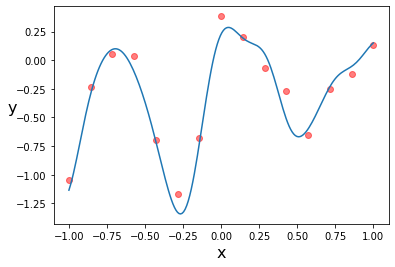

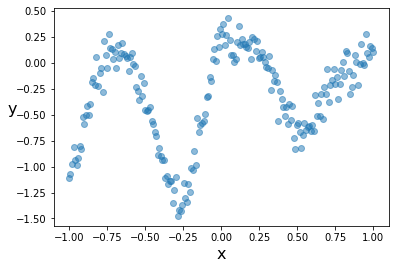

In [2]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
n=15
x  = np.linspace(-1,1,n) # 500 points evenly spaced over [0,1]
xtest = np.linspace(-1,1,200)
x1 = np.hstack([x,xtest]).reshape(-1,1)
# reshape X to make it n*D
mu = np.zeros((len(x1)))# vector of the means
C = k.K(x1,x1)# covariance matrix
# Generate 20 sample path with mean mu and covariance C
np.random.seed(1)
Z= np.random.multivariate_normal(mu,C,1)[0,:]
#training noisy data
y  = Z[0:len(x)]+np.random.randn(len(x))*0.1
#test noisy data
ytest = Z[len(x):]+np.random.randn(len(xtest))*0.1
#tru function
Z = Z[len(x):]
# plotting
pb.figure()
pb.plot(xtest,Z,zorder=100)
pb.scatter(x,y,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("data_1.pdf");
pb.figure()
pb.scatter(xtest,ytest,alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("test_set.pdf");

## Fitting a NN using MLE
This is what Keras does.

We have the usual over-fitting problem for MLE based estimate (the general-recipe ML approach). At the increase of the hidden-units and so of the parameters of the network, the NN starts overfitting!

Using TensorFlow backend.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wil

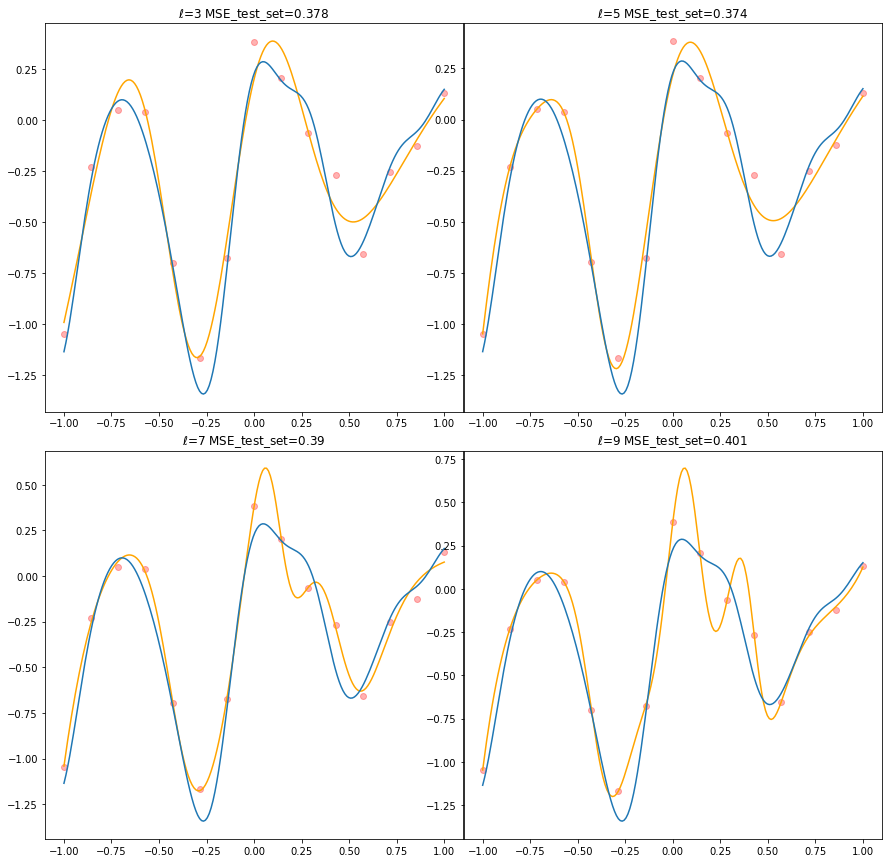

In [3]:
from keras.models import Sequential
from keras.layers import Dense

fig, axs = pb.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

axs = axs.ravel()
d=0
#loop on the number of hidden units
for l in range(3,10,2):   
    # fix random seed for reproducibility
    seed = 7
    np.random.seed(seed)
    # create model
    model = Sequential()
    #inner layer
    model.add(Dense(l, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))
    #outer linear layer
    model.add(Dense(1,  kernel_initializer='normal', activation='linear', name='output_layer'))
    # Compile model
    model.compile(loss='mse',  optimizer='adam')
    #fit model
    history = model.fit(x, y,  epochs=25000, batch_size=200, verbose=0)
    #plot
    y_pred=model.predict(xtest)
    axs[d].plot(xtest,Z,zorder=100,label='true')
    axs[d].plot(xtest,y_pred,c='orange',label='NN')
    axs[d].scatter(x,y,c='r',alpha=0.3)
    axs[d].set_title('$\ell$='+str(l)+' MSE_test_set='+str(np.round(np.mean((y_pred-ytest)**2),3)))
    d=d+1
#pb.savefig("NN_overfitting.pdf",  bbox_inches='tight')
#    return 

In the last plot, you can see the typical example of overfitting. The function fits the data perfectly. Of course, it has also the maximum error
in the test-set

In [13]:
import theano
# we add a column of ones because we want to include an intercept in our model
x1 = np.vstack([np.ones(len(x)),x]).T
floatX = theano.config.floatX

l = 9
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

with pm.Model() as neural_network:
    #we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y)
    #Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    #Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer (like in Linear regression)
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    #standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)
    

#we can do instead an approximated inference
with neural_network:
    inference = pm.SVGD()
    approx = pm.fit(30000, method=inference, obj_optimizer=pm.adam())

100%|██████████| 30000/30000 [01:43<00:00, 288.97it/s]


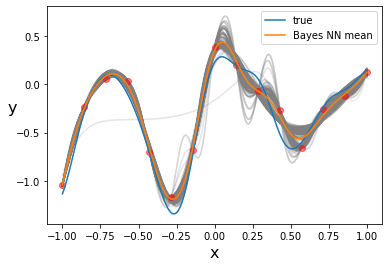

In [15]:
posterior = approx.sample(draws=7000)
    
x1 = np.vstack([np.ones(len(xtest)),xtest]).T
ypred=[]
for i in range(posterior['w_1'].shape[0]):#MC posterior['w_1'].shape[0]
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x1.T))
    #outer layer
    ypred.append(np.dot(posterior['w_0'][i,:],t1))
ypred = np.array(ypred)

#y_es=posterior['act_out'].mean(axis=0)
pb.plot(xtest,Z,label='true',Zorder=100)
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean',Zorder=100)
for i in range(700):
    pb.plot(xtest,ypred[i,:],c='gray',alpha=0.05)
pb.scatter(x,y,c='r',alpha=0.5,Zorder=100)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
#pb.ylim([-1,1.5])
pb.legend()
pb.savefig("BayesNN_l9.pdf")

## We now generate more data

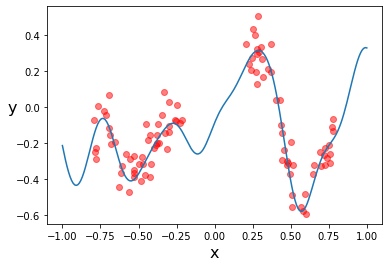

In [19]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
np.random.seed(40)
n=100
x  = np.sort(np.hstack([np.random.rand(int(n/2))*0.6-0.8,np.random.rand(int(n/2))*0.6+0.2])) # 500 points evenly spaced over [0,1]
xtest = np.linspace(-1,1,200)
x1 = np.hstack([x,xtest]).reshape(-1,1)
# reshape X to make it n*D
mu = np.zeros((len(x1)))# vector of the means
C = k.K(x1,x1)# covariance matrix
# Generate 20 sample path with mean mu and covariance C

Z= np.random.multivariate_normal(mu,C,1)[0,:]
y  = Z[0:len(x)]+np.random.randn(len(x))*0.1
ytest = Z[len(x):]+np.random.randn(len(xtest))*0.1
Z = Z[len(x):]
pb.figure()# 
pb.plot(xtest,Z,zorder=100)
pb.scatter(x,y,c='r',alpha=0.5)#training data
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("data.pdf");


In this example, we  first generate a nonlinear functions and then generate noisy training data from this function, but we constrained  the inputs $x$ to belong either to interval $[-0.8,-0.2]$ or  $[0.2,0.8]$.
That means that there is not data in $[-0.2,0.2]$. Our goal is to evaluate the extrapolation error outside $[-0.8,-0.2]$ or  $[0.2,0.8]$

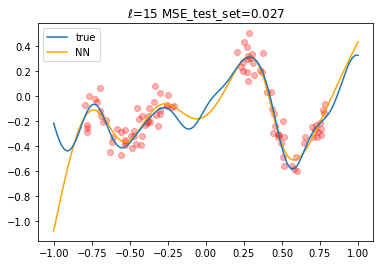

In [20]:
from keras.models import Sequential
from keras.layers import Dense

seed = 7
np.random.seed(seed)
# create model
l=15
model = Sequential()
model.add(Dense(l, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))
model.add(Dense(1,  kernel_initializer='normal', activation='linear', name='output_layer'))
# Compile model
model.compile(loss='mse',  optimizer='adam')
#fit model
history = model.fit(x, y,  epochs=25000, batch_size=200, verbose=0)
#plot
y_pred=model.predict(xtest)
pb.plot(xtest,Z,zorder=100,label='true')
pb.plot(xtest,y_pred,c='orange',label='NN')
pb.scatter(x,y,c='r',alpha=0.3)
pb.title('$\ell$='+str(l)+' MSE_test_set='+str(np.round(np.mean((y_pred[:,0]-ytest)**2),3)))
pb.legend()
pb.savefig("NN_gap.pdf",  bbox_inches='tight')
#    return 

Note that **general-recipe ML does not tell us anything about the uncertainty. For instance,  the estimate
in $[-0.2,0.2]$ should be less reliable than that in $[-0.8,-0.2]$ because there is no data in  $[-0.2,0.2]$.
However, Keras only returns the prediction, there is no uncertainty.**

This together with the overfitting problems shows once again that general-recipe ML is not a sound approach.

## Bayesian NN
Now we address the previous nonlinear regression problem by using a Bayesian NN.

**The model is basically very similar to polynomial regression**. We first define the nonlinear function (NN)
and the place a prior over the unknown parameters. We then compute the posterior.

In [21]:
import theano
# we add a column of ones because we want to include an intercept in our model
x1 = np.vstack([np.ones(len(x)),x]).T
floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

with pm.Model() as neural_network:
    #we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y)
    #Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    #Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer (like in Linear regression)
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    #standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)
    


We can sample some regression lines from the prior as follows.

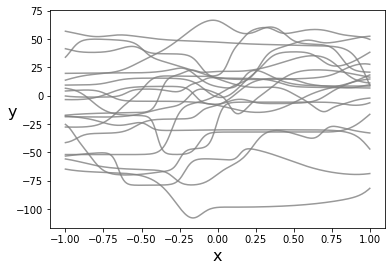

In [22]:
#this can be slow because there are many parameters
with neural_network:
    posterior = pm.sample_prior_predictive(20)
    
x1 = np.vstack([np.ones(len(xtest)),xtest]).T
ypred=[]
for i in range(posterior['w_1'].shape[0]):#MC posterior['w_1'].shape[0]
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x1.T))
    #outer layer
    ypred.append(np.dot(posterior['w_0'][i,:],t1))
ypred = np.array(ypred)

#pb.plot(xtest,Z,label='true')
pb.plot(xtest,ypred.T,label='Bayes NN mean',color='gray',alpha=0.8)
#pb.scatter(x,y,c='r',alpha=0.5)
#pb.legend()
#pb.ylim([-1,1])
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("prior_NN.pdf")

We now compute the posterior.

In [23]:

#we can do instead an approximated inference
with neural_network:
    inference = pm.SVGD()
    approx = pm.fit(70000, method=inference, obj_optimizer=pm.adam())

100%|██████████| 70000/70000 [09:44<00:00, 119.81it/s]


 We then sample from the approximated posterior

In [29]:
posterior = approx.sample(draws=7000)

We compute the prediction for each sample. Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format, that is convenient to do GPU-based training but it is slow when we only need to compute predictions.

In [30]:
x1 = np.vstack([np.ones(len(xtest)),xtest]).T
ypred=[]
for i in range(posterior['w_1'].shape[0]):#MC posterior['w_1'].shape[0]
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x1.T))
    #outer layer
    ypred.append(np.dot(posterior['w_0'][i,:],t1))
ypred = np.array(ypred)

In [31]:
ypred

array([[-2.7062174 , -2.57238318, -2.43705861, ...,  0.21587682,
         0.23214314,  0.24826061],
       [-2.02907583, -1.97941284, -1.92498896, ...,  0.97773501,
         1.05127277,  1.12516516],
       [-2.65746335, -2.54243163, -2.42501467, ...,  1.37998953,
         1.48388148,  1.58881618],
       ...,
       [-2.77636681, -2.73424146, -2.68120284, ...,  0.99656423,
         1.06585054,  1.13504446],
       [-1.21358094, -1.18304163, -1.15106997, ...,  0.20231574,
         0.21715598,  0.2317641 ],
       [-3.13182167, -2.9901054 , -2.84521185, ...,  0.8330611 ,
         0.89626248,  0.9599757 ]])

We first plot the mean  of `ypred`, this is very similar to the prediction that Keras returns

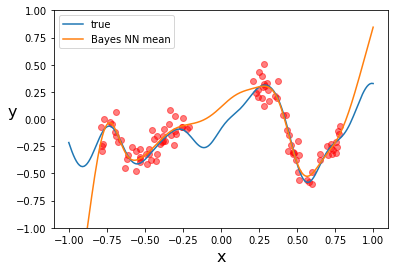

In [32]:
pb.plot(xtest,Z,label='true')
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean')
pb.scatter(x,y,c='r',alpha=0.5)
pb.legend()
pb.ylim([-1,1])
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("BayesNN_mean.pdf")

We now plot the uncertainty, by plotting 500 nonlinear regression lines from the posterior

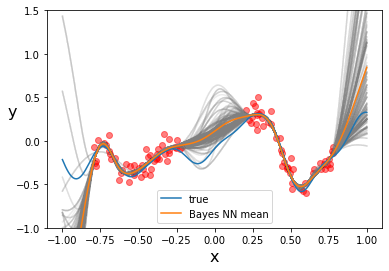

In [33]:
#y_es=posterior['act_out'].mean(axis=0)
pb.plot(xtest,Z,label='true',Zorder=100)
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean',Zorder=100)
for i in range(700):
    pb.plot(xtest,ypred[i,:],c='gray',alpha=0.05)
pb.scatter(x,y,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.ylim([-1,1.5])
pb.legend()
pb.savefig("BayesNN_samples.pdf")

## 

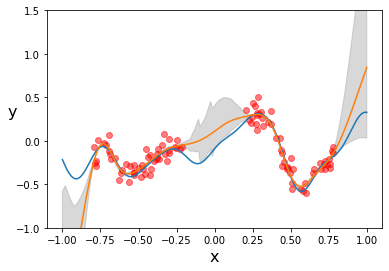

In [34]:
#y_es=posterior['act_out'].mean(axis=0)
pb.plot(xtest,Z,label='true',Zorder=100)
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean',Zorder=100)
sig = pm.hpd(ypred, credible_interval=0.95)
pb.fill_between(xtest, sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.scatter(x,y,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.ylim([-1,1.5])
pb.savefig("BayesNN_hpd.pdf")

## Gaussian process

They are equivalent to a NN with infinite hidden-units

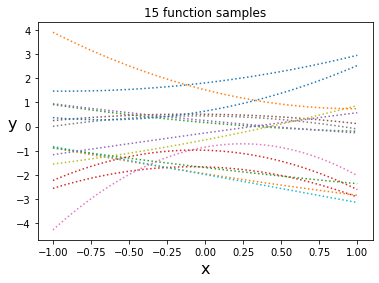

In [35]:
#quadratic polynomial kernel
def K(x_1,x_2,alpha, degree):
    xx1 = x_1**np.arange(0,deg+1)
    xx2 = x_2**np.arange(0,deg+1)
    return np.linalg.multi_dot([xx1,np.diag(alpha),xx2.T])

x = np.linspace(-1,1,50).reshape(-1,1)
deg=2
alpha=np.ones(deg+1)
f = np.random.multivariate_normal(np.zeros(len(x)),K(x,x, alpha, degree=deg),15)
pb.plot(x,f.T,':');
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("15 function samples")
pb.savefig("poly2.pdf");

In [36]:
f = np.random.multivariate_normal(np.zeros(len(x)),K(x,x, np.ones(deg+1), degree=deg),15000)
sig = pm.hpd(f, alpha=0.05)
pb.fill_between(x[:,0], sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.plot(x,np.mean(f,axis=0),label='mean')
pb.legend()
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("Prior 95% HPD")
pb.savefig("poly_hpd.pdf");

TypeError: hpd() got an unexpected keyword argument 'alpha'

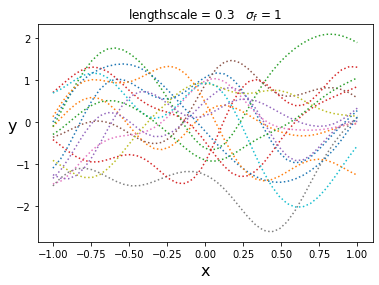

In [37]:
#square exponential Kernel
def K(x_1,x_2, lengthscale, sigma_f):
    sqdist = np.sum(x_1**2/lengthscale**2, 1).reshape(-1, 1) + np.sum(x_2**2/lengthscale**2, 1) - 2 * np.dot(x_1/lengthscale**2, x_2.T)
    return sigma_f**2 * np.exp(-0.5 * sqdist)

x = np.linspace(-1,1,40).reshape(-1,1)
lengthscale=np.ones(1)*0.3
sigma_f=1
f = np.random.multivariate_normal(np.zeros(len(x)),K(x,x, lengthscale, sigma_f),15)
pb.plot(x,f.T,':');
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("lengthscale = "+str(lengthscale[0]) + "   " + "$\sigma_f$ = "+str(sigma_f) )
pb.savefig("RBF_03.pdf");

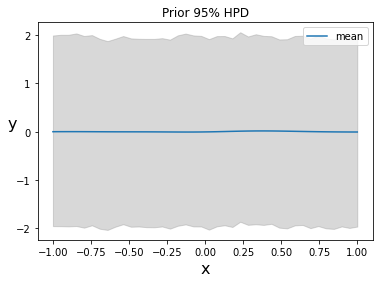

In [42]:
f = np.random.multivariate_normal(np.zeros(len(x)),K(x,x, lengthscale, sigma_f),15000)
sig = pm.hpd(f, credible_interval=0.95)
pb.fill_between(x[:,0], sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.plot(x,np.mean(f,axis=0),label='mean')
pb.legend()
pb.title("Prior 95% HPD")
pb.savefig("rbf_hpd_3.pdf");

In [43]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the sufficient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s. Args: X_s: 
    New input locations (n x d). X_train: Training locations (m x d). Y_train: 
    Training targets (m x 1). l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. 
    sigma_y: Noise parameter. Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K0 = K(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = K(X_train, X_s, l, sigma_f)
    K_ss = K(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K0)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [44]:
np.random.seed(42)
xa=np.array([[0,0.3,-0.8,0.2,0.5,-0.4,-0.6]]).reshape(-1,1)
x1=np.linspace(-1,1,50).reshape(-1,1)
ya = np.random.multivariate_normal(np.zeros(len(xa)),K(xa,xa, lengthscale, sigma_f),1).T
x=xa[0:4,:]
y=ya[0:4,:]
mu, cov =posterior_predictive(x1, x, y, l=lengthscale, sigma_f=sigma_f, sigma_y=1e-8)

## Posterior after i observations

(-3.75, 3.75)

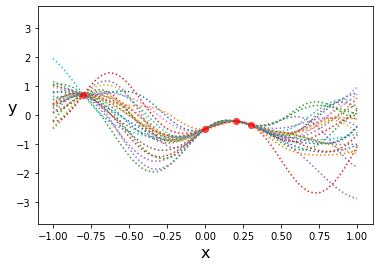

In [45]:
f_post = np.random.multivariate_normal(mu[:,0], cov, 25)
pb.plot(x1,f_post.T,':');
pb.scatter(x,y,c='r',alpha=0.7,Zorder=100)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("o4.pdf")
pb.ylim([-3.75,3.75])
#pb.plot(x,np.mean(f,axis=0),label='mean')

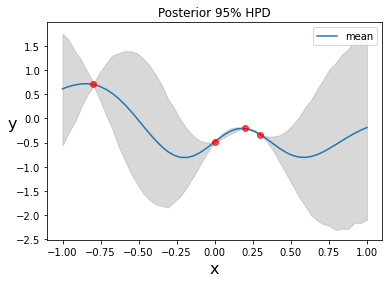

In [46]:
f_post = np.random.multivariate_normal(mu[:,0], cov, 14550)
sig = pm.hpd(f_post, credible_interval=0.95)
pb.fill_between(x1[:,0], sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.plot(x1,np.mean(f_post,axis=0),label='mean')
pb.scatter(x,y,c='r',alpha=0.7,Zorder=100)
pb.legend()
pb.title("Posterior 95% HPD")
pb.savefig("rbf_hpd_post.pdf");

## 50 observations

 /home/benavoli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:covariance is not positive-semidefinite.


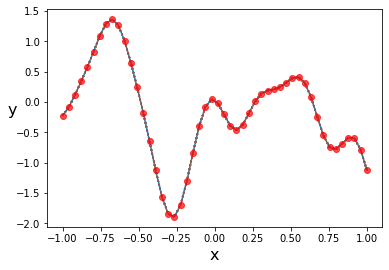

In [47]:
lengthscale=0.15
np.random.seed(42)
x=np.linspace(-1,1,50).reshape(-1,1)
x1=np.linspace(-1,1,50).reshape(-1,1)
y = np.random.multivariate_normal(np.zeros(len(x)),K(x,x, lengthscale, sigma_f),1).T
pb.plot(x,y);

mu, cov =posterior_predictive(x1, x, y, l=lengthscale, sigma_f=sigma_f, sigma_y=1e-5)
f_post = np.random.multivariate_normal(mu[:,0], cov, 25)
pb.plot(x1,f_post.T,':');
pb.scatter(x,y,c='r',alpha=0.7,Zorder=100)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("om.pdf")

#### With noise in the data

In [48]:
np.random.seed(42)
xa=np.array([[0,0.3,-0.8]]).reshape(-1,1)
x1=np.linspace(-1,1,50).reshape(-1,1)
ya = np.random.multivariate_normal(np.zeros(len(xa)),K(xa,xa, lengthscale, sigma_f),1).T
ya=ya + np.random.randn(ya.shape[0],ya.shape[1])*0.2
x=xa[0:3,:]
y=ya[0:3,:]
mu, cov =posterior_predictive(x1, x, y, l=lengthscale, sigma_f=sigma_f, sigma_y=0.2)

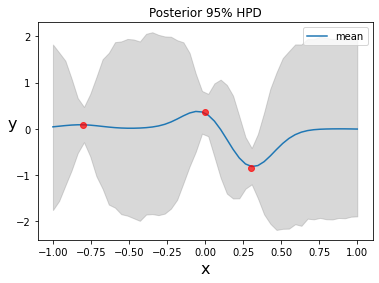

In [49]:
f_post = np.random.multivariate_normal(mu[:,0], cov, 14550)
sig = pm.hpd(f_post, credible_interval=0.95)
pb.fill_between(x1[:,0], sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.plot(x1,np.mean(f_post,axis=0),label='mean')
pb.scatter(x,y,c='r',alpha=0.7,Zorder=100)
pb.legend()
pb.title("Posterior 95% HPD")
pb.savefig("rbf_hpd_postn.pdf");

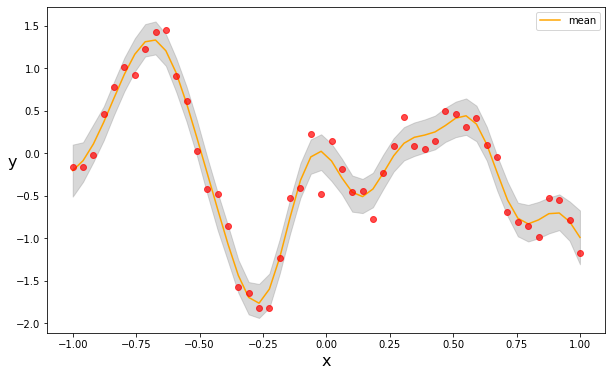

In [51]:
lengthscale=0.15
np.random.seed(42)
x=np.linspace(-1,1,50).reshape(-1,1)
x1=np.linspace(-1,1,50).reshape(-1,1)
y = np.random.multivariate_normal(np.zeros(len(x)),K(x,x, lengthscale, sigma_f),1).T
y=y + np.random.randn(y.shape[0],y.shape[1])*0.2
pb.figure(figsize=(10,6))
#pb.plot(x,y);


mu, cov =posterior_predictive(x1, x, y, l=lengthscale, sigma_f=sigma_f, sigma_y=0.2)
f_post = np.random.multivariate_normal(mu[:,0], cov, 500)
pb.plot(x,np.mean(f_post,axis=0),color='orange',label='mean')
sig = pm.hpd(f_post, credible_interval=0.95)
pb.fill_between(x1[:,0], sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.scatter(x,y,c='r',alpha=0.7,Zorder=100)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.savefig("omn.pdf")

In [131]:
f_post

array([[ 1.04253879,  1.02290058,  0.97456527, ..., -0.91872282,
        -0.85125227, -0.76674771],
       [ 0.13065807,  0.25942963,  0.38044074, ..., -0.16302798,
        -0.04007407,  0.08814952],
       [ 1.11599424,  1.08467234,  1.02780351, ..., -1.05530477,
        -0.9715808 , -0.85137194],
       ...,
       [ 0.82608326,  0.74815542,  0.69911384, ...,  0.37176074,
         0.37427316,  0.36493951],
       [-0.20334045, -0.02403427,  0.16264076, ...,  0.64833969,
         0.86875774,  1.08893022],
       [ 1.88740164,  1.72914791,  1.52173484, ...,  0.89697143,
         1.12649876,  1.35945355]])